# Reflection


In the context of LLM agent building, reflection refers to the process of prompting an LLM to observe its past steps (along with potential observations from tools/the environment) to assess the quality of the chosen actions.
This is then used downstream for things like re-planning, search, or evaluation.


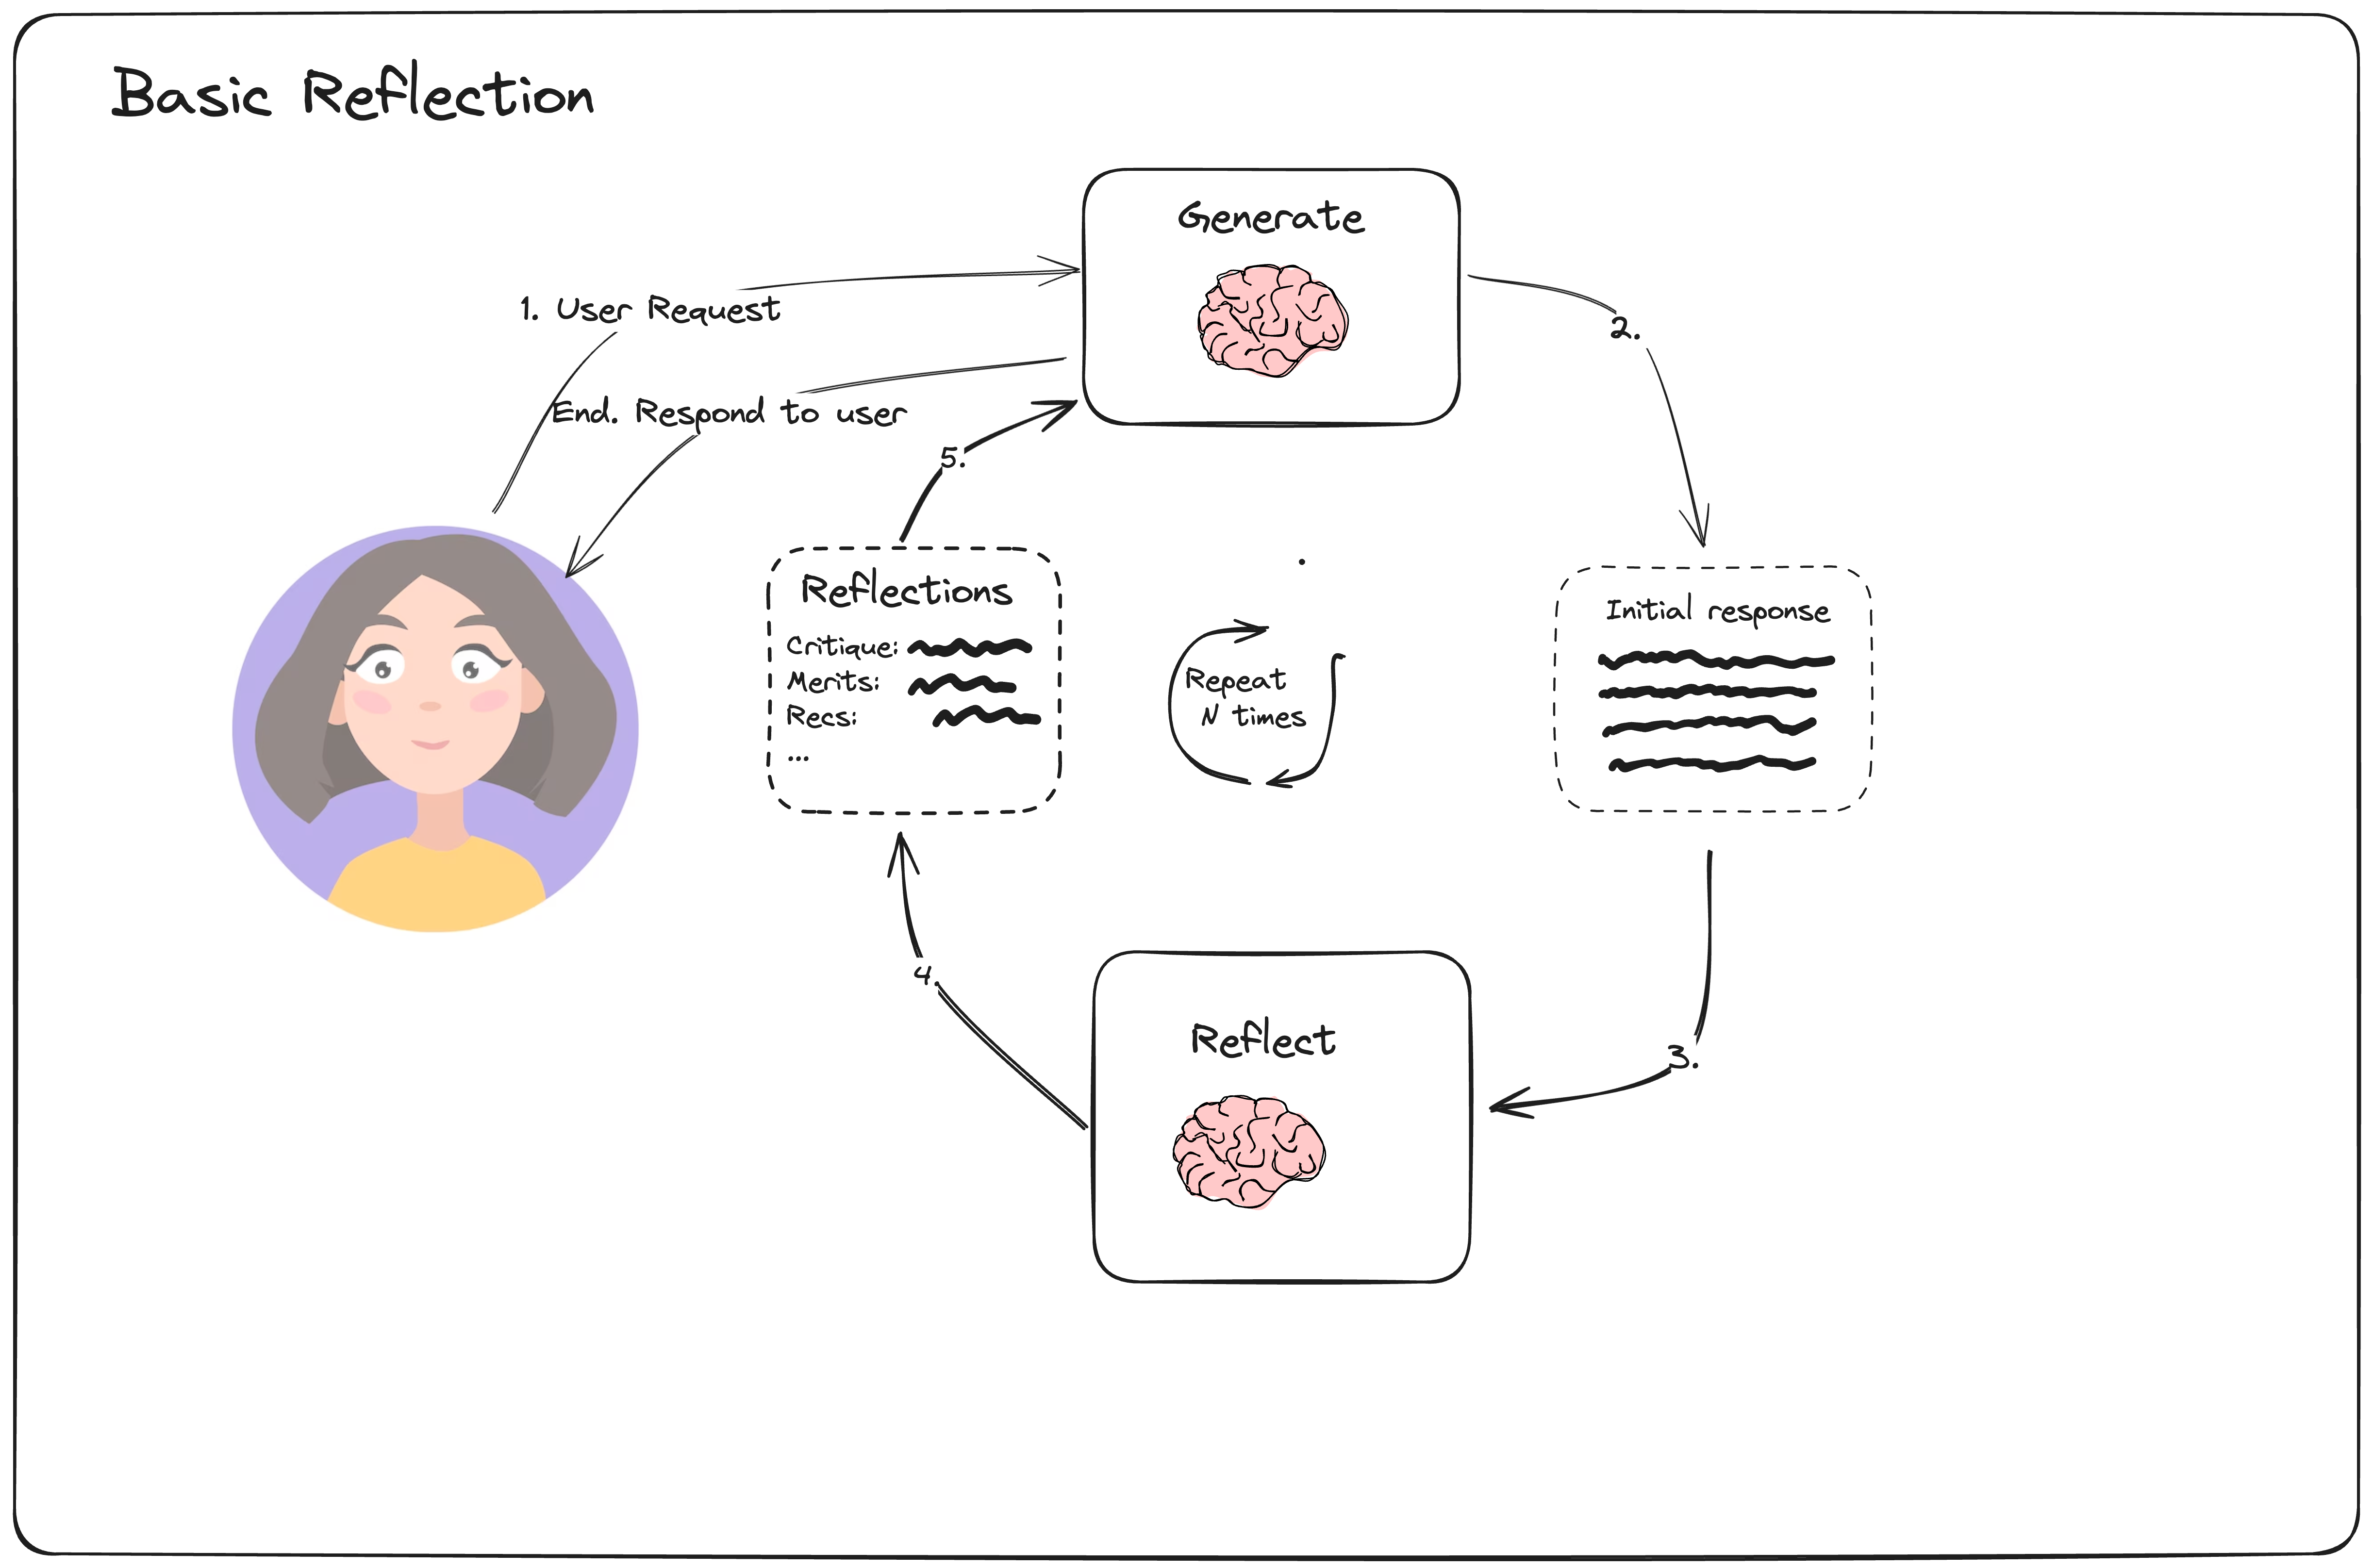

#### Prerequisites

We will be using a basic agent with a search tool here.

In [1]:
%pip install -U --quiet  langgraph langchain-openai
%pip install -U --quiet tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 760.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.0/372.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.6/328.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 3.6 MB/s eta 0:00:00


In [2]:
import getpass
import os


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


# Optional: Configure tracing to visualize and debug the agent
_set_if_undefined("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

_set_if_undefined("OPENAI_API_KEY")

LANGCHAIN_API_KEY··········
OPENAI_API_KEY··········


## Generate

For our example, we will create a "5 paragraph essay" generator. First, create the generator:


In [3]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatOpenAI(
    model="gpt-3.5-turbo"
)
generate = prompt | llm

In [4]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

"The Little Prince" by Antoine de Saint-Exupéry continues to captivate readers of all ages, making it a timeless classic that remains relevant in modern childhood. This enchanting tale explores profound themes such as friendship, love, imagination, and the complexities of human nature, which resonate with children in today's world.

Firstly, the Little Prince's quest to understand the adult world mirrors the curiosity and innocence of children today. In a fast-paced and technology-driven society, where children are often exposed to adult realities at a young age, the Little Prince's inquiries about life, relationships, and the meaning of existence can guide modern children in navigating their own questions and uncertainties.

Secondly, the Little Prince's emphasis on the importance of imagination and creativity is particularly pertinent in the context of modern childhood. In an era dominated by screens and digital distractions, encouraging children to embrace their imagination, explore

### Reflect

In [5]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [6]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Your essay on why "The Little Prince" is relevant in modern childhood is well-structured and insightful. You have effectively highlighted key themes from the book and connected them to contemporary issues facing children today. However, here are some suggestions to enhance your essay:

1. **Introduction**: Consider adding a more engaging and attention-grabbing introduction that sets the stage for discussing the relevance of "The Little Prince" in modern childhood. You could start with a compelling anecdote, a relevant quote from the book, or a thought-provoking question.

2. **Thematic Analysis**: While you briefly touched upon themes like friendship, imagination, and connection, you could deepen your analysis by providing specific examples from the book to illustrate how these themes are relevant to modern childhood. Dive into how these themes can help children navigate challenges and foster personal growth in today's world.

3. **Impact on Children**: Expand on how the lessons learne

### Repeat

And... that's all there is too it! You can repeat in a loop for a fixed number of steps, or use an LLM (or other check) to decide when the finished product is good enough.

In [7]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

"The Little Prince" by Antoine de Saint-Exupéry continues to resonate with modern childhood, offering timeless wisdom and insights that guide young readers through the complexities of life. From its profound themes to its whimsical storytelling, the book remains a cherished classic that captures the hearts and minds of children today.

To start, imagine a child picking up "The Little Prince" for the first time, drawn into a world of magic and wonder where a little prince explores the universe in search of meaning. This captivating introduction sets the stage for a journey that mirrors the curiosity and innocence of modern children, who are navigating a world filled with uncertainties and challenges beyond their years.

As the Little Prince encounters various characters on his travels, such as the fox and the rose, he learns valuable lessons about friendship, love, and the essence of human connection. These themes are especially relevant in today's society, where children are often face

## Define graph

Now that we've shown each step in isolation, we can wire it up in a graph.

In [8]:
from typing import List, Sequence

from langgraph.graph import END, MessageGraph, START


async def generation_node(state: Sequence[BaseMessage]):
    return await generate.ainvoke({"messages": state})


async def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = await reflect.ainvoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

In [9]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Generate an essay on the topicality of The Little Prince and its message in modern life"
        )
    ],
):
    print(event)
    print("---")

{'generate': AIMessage(content='"The Little Prince" by Antoine de Saint-Exupéry remains a timeless classic that continues to resonate with readers of all ages due to its profound and universal message. In today\'s fast-paced and materialistic world, the themes explored in the novella are more relevant than ever. The story follows a young prince who travels from planet to planet, encountering various characters who symbolize different aspects of human nature. Through these encounters, Saint-Exupéry conveys essential life lessons about love, friendship, and the importance of seeing beyond the surface to appreciate the true essence of things.\n\nOne of the central messages of "The Little Prince" is the importance of cultivating meaningful relationships and connections. In a world where technology often substitutes for genuine human interaction, the story reminds us of the value of emotional connections and the beauty of forming deep and authentic relationships. The Little Prince cherishes

In [18]:
event['generate'].content

'"The Little Prince" by Antoine de Saint-Exupéry resonates with readers of all ages due to its timeless themes of love, friendship, imagination, and authenticity, which hold significant relevance in navigating the complexities of modern life. In today\'s fast-paced and materialistic world, the novella\'s messages offer valuable insights into the pitfalls of consumerism, the importance of self-discovery, and the power of imagination.\n\nSaint-Exupéry critiques consumerism through the encounters of the Little Prince with characters like the Rose and the businessman, who symbolize the emptiness of pursuing material wealth and external validation. The novella serves as a cautionary tale, highlighting the consequences of prioritizing possessions over spiritual fulfillment and genuine human connection. By exploring these themes, readers are prompted to reflect on their own attitudes towards consumerism and consider how they can cultivate a more meaningful and authentic existence in a society

## Conclusion

Now that you've applied reflection to an LLM agent, I'll note one thing: self-reflection is inherently cyclic: it is much more effective if the reflection step has additional context or feedback (from tool observations, checks, etc.). If, like in the scenario above, the reflection step simply prompts the LLM to reflect on its output, it can still benefit the output quality (since the LLM then has multiple "shots" at getting a good output), but it's less guaranteed.
